In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timeit,time
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import math
from random import*
import random
from numpy.testing import assert_almost_equal

In [2]:
from cvxopt import normal
from cvxopt import matrix
from numpy import array

In [3]:
from l1 import l1
import pandas as pd
import statistics as st

In [4]:
def l1_regression(A,b):
    A = matrix(A) # converitng to matrix, format accepted by the solver
    b = matrix(b)
    return l1(A,b)

# Plots

In [5]:
def plots(x,y1,y2,y3,y4):
    plt.figure(figsize=(8,6),dpi=80)
    plt.scatter(x,y1,color="red",label='l1_Leverage Score')
    plt.plot(x,y1,color="red",linewidth=2.0,linestyle="--")
    
    plt.scatter(x,y2,color="green",label='l2_leverage Score')
    plt.plot(x,y2,color="green",linewidth=2.0,linestyle="--")
    
    plt.scatter(x,y3,color="orange",label='Kmeans++')
    plt.plot(x,y3,color="orange",linewidth=2.0,linestyle="--")

    plt.scatter(x,y4,color="blue",label='Uniform Sampling')
    plt.plot(x,y4,color="blue",linewidth=2.0,linestyle="--")
    #plt.xlabel('---Sketched Matrix size--->')
    plt.xlabel('----Sketch size (rows)')
    plt.ylabel('---Ratio(Approximation/Optimal)-->')
    plt.legend()
    plt.grid(b=True)
    plt.show()

In [6]:
def quantilePlot(x,d1,d2,d3,d4):
    plt.figure(num=1,figsize=(10,8))
    df1= pd.DataFrame(d1.T,columns=x)
    df1.boxplot()
    plt.title('l1_Leverage score')

    plt.figure(num=2,figsize=(10,8))
    df2= pd.DataFrame(d2.T,columns=x)
    df2.boxplot()
    plt.title('l2_leverageScore')
    #print("KPP- matrix")
    #print(d3)
    plt.figure(num=3,figsize=(10,8))
    df3=pd.DataFrame(d3.T,columns=x)
    df3.boxplot()
    plt.title('KPP')
    #print("df3\n",df3)
    
    plt.figure(num=4,figsize=(10,8))
    df4=pd.DataFrame(d4.T,columns=x)
    df4.boxplot()
    plt.title('USS')

In [7]:
def plots_leverage_Kpp(x,y1,y2):
    plt.figure(figsize=(8,6),dpi=80)
    plt.scatter(x,y1,color="red",label='Leverage Score')
    plt.plot(x,y1,color="red",linewidth=2.0,linestyle="--")
    plt.scatter(x,y2,color="yellow",label='Kmeans++')
    plt.plot(x,y2,color="yellow",linewidth=2.0,linestyle="--")
    plt.xlabel('---Sketched Matrix size--->')
    plt.ylabel('---Ratio(Approximation/Optimal)-->')
    plt.legend()
    plt.grid(b=True)
    plt.show()

# Datasets

In [8]:
def GA(n,d):
    C = np.zeros((d,d)) # covariance matrix
    for i in range(d):
        for j in range(d):
            C[i][j] = 2*(0.5**abs(i-j))
    mean = np.ones(d)
    X = np.random.multivariate_normal(mean,C,(n)) # this is A
    beta = list()
    beta.extend(np.ones(10))
    beta.extend(0.1*np.ones(d-20))
    beta.extend(np.ones(10))
    beta = np.array(beta)
    noise = np.random.normal(loc=0.0,scale =9,size=n)
    y = X.dot(beta) + noise # this is b
    return X,y

In [9]:
def T3(n,d):
    df = 3
    C = np.zeros((d,d)) # covariance matrix
    for i in range(d):
        for j in range(d):
            C[i][j] = 2*(0.5**abs(i-j))
    mean = np.ones(d)
    x = np.random.chisquare(df, n)/df
    X = np.random.multivariate_normal(mean,C,(n))
    X = X/np.sqrt(x)[:,None]
    beta = list()
    beta.extend(np.ones(10))
    beta.extend(0.1*np.ones(d-20))
    beta.extend(np.ones(10))
    beta = np.array(beta)
    noise = np.random.normal(loc=0.0,scale =20,size=n)
    y = X.dot(beta) + noise # this is b
    return X,y

In [33]:
def T1(n,d):
    df = 1
    C = np.zeros((d,d)) # covariance matrix
    for i in range(d):
        for j in range(d):
            C[i][j] = 2*(0.5**abs(i-j))
    mean = np.ones(d)
    x = np.random.chisquare(df, n)/df
    X = np.random.multivariate_normal(mean,C,(n))
    X = X/np.sqrt(x)[:,None]
    beta = list()
    beta.extend(np.ones(10))
    beta.extend(0.1*np.ones(d-20))
    beta.extend(np.ones(10))
    beta = np.array(beta)
    noise = np.random.normal(loc=0.0,scale =100,size=n)
    y = X.dot(beta) + noise # this is b
    return X,y

# Sampling Techniques

## l1 leverage score

In [11]:
def l1_LSS(A,b):
    l1norm=list() #for storing l1 norm across various size changes
    iter_data=[]
    #aug_A = np.c_[A,b]
    #u,e,vt = np.linalg.svd(aug_A,full_matrices=False)
    u,e,vt = np.linalg.svd(A,full_matrices=False)
    leveragescore = np.sum(np.abs(u),axis=1) # for rows the matrix considered is column :
    prob = leveragescore/sum(leveragescore)
    
    for k in s: # s represent the lsit of number of cluster
        r=0
        temp_data=list()
        for i in range(10):
            index = np.random.choice(row,k,replace = False,p=prob)
            #C = aug_A[index]
            #A_sketch = C[:,:-1]
            #print(np.linalg.matrix_rank(A_sketch))
            #b_sketch = C[:,-1]
            #regression call
            A_sketch = A[index,:]
            b_sketch = b[index]
            x_tilde = array(l1_regression(A_sketch,b_sketch))
            regression_value=np.linalg.norm((A.dot(x_tilde)-b),ord=1)
            temp_data.append(regression_value)
            r+=regression_value
        r/=10
        iter_data.append(temp_data)
        
        l1norm.append(r)
    #print(iter_data)
    ratio = np.array(l1norm)/np.array(l1normOpt)
    #print("LSS:(s,l1norm,l1norm/l1normopt) ",list(zip(s,l1norm,ratio)))
    return ratio,np.array(iter_data)

## L2 leverage score

In [12]:
def LSS(A,b):
    l1norm=list() #for storing l1 norm across various size changes
    iter_data=[]
    #aug_A = np.c_[A,b] # augmenting
    #u,e,vt = np.linalg.svd(aug_A,full_matrices=False)
    u,e,vt = np.linalg.svd(A,full_matrices=False)
    #print(np.linalg.matrix_rank(aug_A))
    leveragescore = np.sum(np.square(np.abs(u)),axis=-1) # for rows the matrix considered is column :
    prob = leveragescore/sum(leveragescore)
    for k in s: # s represent the lsit of number of cluster
        r=0
        temp_data=list()
        #print("---- ranks for the sketch size",k)
        for i in range(10):
            index = np.random.choice(row,k,replace = False,p=prob)
            A_sketch = A[index,:]
            #A_sketch = C[:,:-1]
         #   print(np.linalg.matrix_rank(A_sketch))
            #b_sketch = C[:,-1]
            b_sketch=b[index]
            #regression call
            x_tilde = array(l1_regression(A_sketch,b_sketch))
            regression_value=np.linalg.norm((A.dot(x_tilde)-b),ord=1)
            temp_data.append(regression_value)
            r+=regression_value
        r/=10
        iter_data.append(temp_data)
        
        l1norm.append(r)
    #print(iter_data)
    ratio = np.array(l1norm)/np.array(l1normOpt)
    #print("LSS:(s,l1norm,l1norm/l1normopt) ",list(zip(s,l1norm,ratio)))
    return ratio,np.array(iter_data)

## Uniform Sampling


In [13]:
def USS(A,b):
    l1norm = []
    ratio=[]
    iter_data=[]
    for k in s:
        r=0
        temp_data=[]
        #print("k is----",k)
        for i in range(10):
            index = np.random.choice(row,k,replace=False)
            #for t in range(k):
            #    index.append(int(random.uniform(0,row)))
            #index=randint(0, 9)
            #index = np.int_((np.random.uniform(low=0,high=row,size=k)))
            A_sketch = A[index,:]
            b_sketch = b[index]
            print(np.linalg.matrix_rank(A_sketch))
            x_tilde = array(l1_regression(A_sketch,b_sketch))
            regression_value = np.linalg.norm((A.dot(x_tilde)-b),ord=1)
            temp_data.append(regression_value)
            r+=regression_value
        r/=10
        iter_data.append(temp_data)
        l1norm.append(r)
    ratio=np.array(l1norm)/np.array(l1normOpt)
    return ratio,np.array(iter_data)

## LandMark Selection

In [14]:
def LMS(A,b):
    l1norm = list()  # this is for sketched
    ratio = list()
    iter_data=[]
    aug_A = np.c_[A,b]
    for k in s:
        r=0
        temp_data=[]
        for i in range(10):   
            k_cluster=KMeans(n_clusters=k,init='random',n_init=1,max_iter=50).fit(aug_A)
            C = k_cluster.cluster_centers_
            A_sketch = C[:,:-1] # placing the first d columns in A sketch
            b_sketch = C[:,-1]  #placing the (d+1)th column in b
            x_tilde = array(l1_regression(A_sketch,b_sketch))
            regression_value=np.linalg.norm((A.dot(x_tilde)-b),ord=1)
            temp_data.append(regression_value)
            r+=regression_value
        r/=10
        iter_data.append(temp_data)
        l1norm.append(r)
        # only for sketched matrix
    ratio = np.array(l1norm)/np.array(l1normOpt)
    #print("LMS:(s,l1norm,l1norm/l1normopt)",list(zip(s,l1norm,ratio)))
    return ratio,np.array(iter_data)

## KPP

In [15]:
def KPP(A,b):
    l1norm = list()
    ratio = list()
    iter_data=list()
    aug_A = np.c_[A,b]
    for k in s:
        #print("-----for the sketch size:",k)
        r=0
        temp_data=[]
        for i in range(10):
            k_cluster=KMeans(n_clusters=k,init='k-means++',n_init=1,max_iter=50).fit(aug_A)
            C = k_cluster.cluster_centers_
            A_sketch = C[:,:-1] # placing the first d columns in A sketch
            b_sketch = C[:,-1]#placing the (d+1)th column in b
            x_tilde = array(l1_regression(A_sketch,b_sketch)) 
            regression_value=np.linalg.norm((A.dot(x_tilde)-b),ord=1)
            temp_data.append(regression_value)
            r+=regression_value
            #print(regression_value/l1normOpt) 
        r/=10
        iter_data.append(temp_data)
        #print(temp_data)
        l1norm.append(r)
    ratio = np.array(l1norm)/np.array(l1normOpt)
    #print(l1normOpt)
    #print("KPP:(s,l1norm,l1norm/l1normopt) ",list(zip(s,l1norm,ratio)))
    return ratio,np.array(iter_data)

In [ ]:
def initKPP():
    l1norm = []
    ratio = []
    iter_data = []
    
    for k in s:
        r = 0
        temp_data=[]
        
        
    

## SKPP
### 4 cells below

In [16]:
def SKPP():
    global l1Matrix
    global factor,s
    global C_dash,C_index,mcp
    
    C_dash.clear()
    C_index.clear()
    x=0
    y=0
    for f in factor:
        for k in s:
            l1norm_temp=0
            const = 10
            # --- running it multiple times to take the average 
            for i in range(const):  
                C_dash.clear()
                C_index.clear()
                mcp = np.full((3,row),np.inf)
                wC = KmeansP(f*k)
                k_cluster=KMeans(n_clusters=k,init='k-means++',n_init=1,max_iter=1,random_state=0).fit(wC)
                C = k_cluster.cluster_centers_
                A_sketch = C[:,:-1]
                b_sketch = C[:,-1]
                x_tilde = array(l1_regression(A_sketch,b_sketch))
                # for plotting purpose
                l1norm_temp += np.linalg.norm((A.dot(x_tilde))-b,ord=1)
            l1Matrix[x][y]=l1norm_temp/const
            y+=1
        x+=1
        y=0
    l1Matrix = l1Matrix/l1normOpt
    return l1Matrix[0][:]

In [17]:
def KmeansP(l): # augmented A is passed
    global C_index,C_dash,aug_A,row,mcp
    
    index= int(np.random.choice(row,1))
    C_index.add(index)
    C_dash.add(index)
    
    loop=5
    # Calculate probability of each point of x
    for i in range(loop):
    #-- computing the distance of each point to its nearest center 
        if(len(C_dash)>0):
            computeDist() #-- Calling distance
            phi = np.sum(mcp[0][:])  # summing up the first row corresponding to the distances

            mcp[2][:] = np.multiply(mcp[0][:],l)/phi # storing the squared distances of each point to nearest cluster
            u,c=np.unique(mcp[1][:], return_counts=True)
    
        #--- Sampling x independently from X with above computed probability
        for j in range(row):
            if(mcp[2][j]>np.random.random()):
                C_dash.add(j) # this is C'
        C_dash=C_dash.difference(C_index)
        C_index=C_index.union(C_dash)
    # loop ends
    
    # weight computation
    unique,counts = computeWeight()
    unique = [int(w) for w in unique]
    weighted_C = np.multiply(aug_A[unique],counts[:,np.newaxis])
    return weighted_C

In [18]:
def computeDist():
    global C_dash
    global mcp
    global aug_A
    global row
    for i in range(row):
        for c in C_dash:
            eucd_dist = np.square(np.linalg.norm(abs(aug_A[i]-aug_A[c]),ord=2))
            if(mcp[0][i] > eucd_dist or mcp[0][i]==np.inf):
                mcp[0][i]=eucd_dist
                mcp[1][i]=c

In [19]:
def computeWeight():
    global mcp
    unique,counts = np.unique(mcp[1][:], return_counts=True)
    #print(unique.shape,counts.shape)
    return unique.tolist(), counts

# Inputs

In [20]:
n= int(input("Number of rows: "))
d=int(input("Number of columns >20: "))
row = n
#s = [row,row/25,row/32,row/35,row/40,row/50,row/64]
factor=[1]

#mcp = np.full((3,row),np.inf)
C_index = set([]) # for storing index of cluster chosen from A
C_dash = set([])
# mindist_cluster_probability = mcp
# mindist 1st row: for storing min dist
# mindist 2 row: to which cluster
# mindist 3rd row: prob

In [21]:
orderK = d*np.log2(d)
s = [0.5*orderK,0.85*orderK,0.95*orderK,1*orderK,1.15*orderK,1.25*orderK]
s = [round(int(x)) for x in s]
#s=s[::-1] # reversing the list
print(s)

[58, 98, 110, 116, 133, 145]


# Execution Function

In [22]:
def execute(A,b):
    #r2,r3= controller2(A,b)
    #print(min(r3),max(r3))
    r1,r2,r3,r4,d1,d2,d3,d4=controller2(A,b)
    plots(s,r1,r2,r3,r4)
    #quantilePlot(s,d1,d2,d3,d4)
    #plots_leverage_Kpp(s,r1,r3)
    #return r1,r3

In [23]:
def controller2(A,b):
    r1,d1 = l1_LSS(A,b)
    r2,d2 = LSS(A,b)
    r3,d3 = KPP(A,b)
    r4,d4 = USS(A,b)
    #r5 = SKPP()
    #return r1,r2,r3
    return r1,r2,r3,r4,d1,d2,d3,d4

# Outputs

## GA

In [24]:
#from l1 import l1
A,b=GA(n,d)
x_opt = array(l1_regression(A,b))
l1normOpt = np.linalg.norm((A.dot(x_opt)-b),ord=1)
l1Matrix = np.zeros((len(factor),len(s)))
aug_A = np.c_[A,b]
row,col = aug_A.shape

122786.10359728031
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25


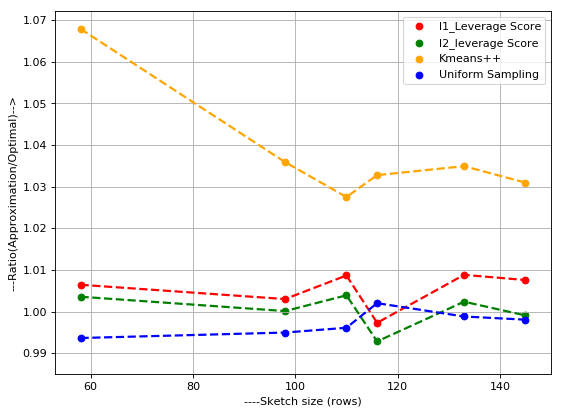

In [25]:
#leverageScore(A)
print(l1normOpt)
execute(A,b)

GA: dimension of matrix- 2000 x 32
l1normOpt:  91325.66606444187
33


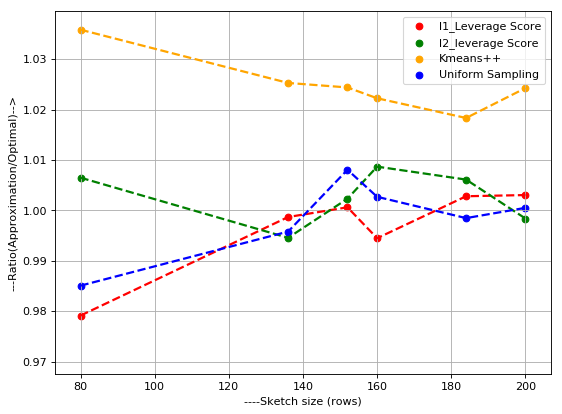

In [326]:
print("GA: dimension of matrix-",n,"x",d)
#mcp = np.full((3,row),np.inf)
print("l1normOpt: ",l1normOpt)
execute(A,b)

GA: dimension of matrix- 1500 x 32
l1normOpt:  55240.99123447202


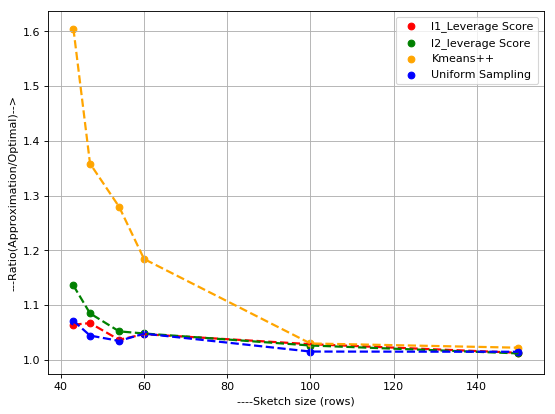

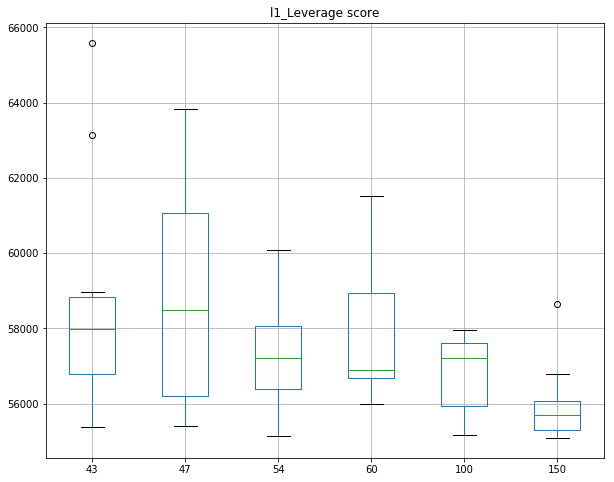

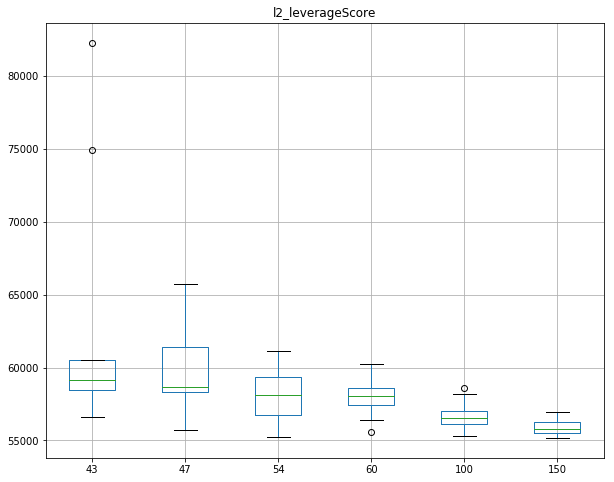

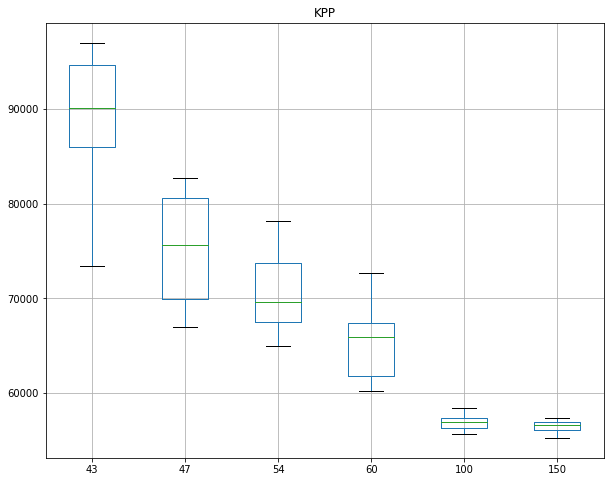

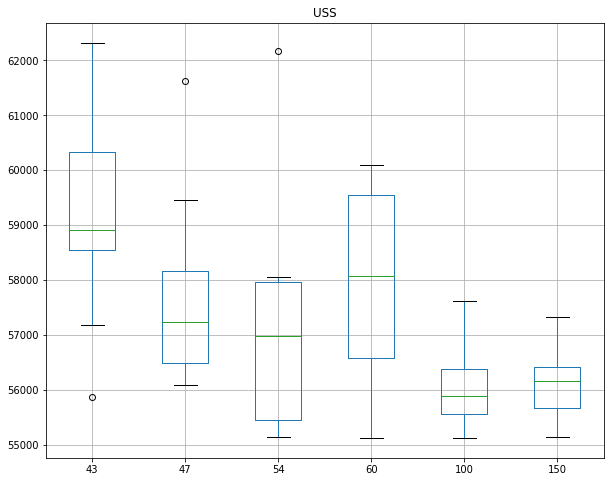

In [51]:
print("GA: dimension of matrix-",n,"x",d)
#mcp = np.full((3,row),np.inf)
print("l1normOpt: ",l1normOpt)
execute(A,b)

## T3

In [86]:
A,b = T3(n,d)
x_opt = array(l1_regression(A,b))
l1normOpt = np.linalg.norm((A.dot(x_opt)-b),ord=1)
l1Matrix = np.zeros((len(factor),len(s)))
aug_A = np.c_[A,b]
row,col = aug_A.shape

425947.54275049054
27


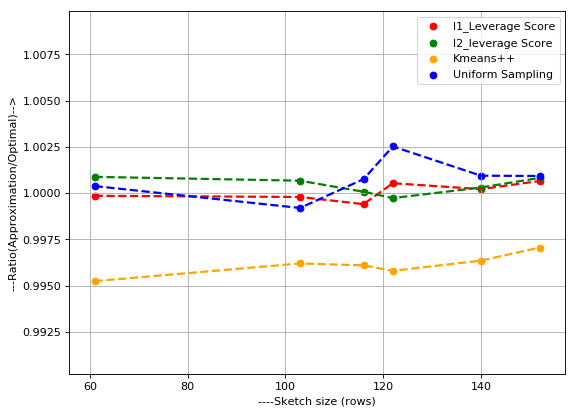

In [87]:
print(l1normOpt)
execute(A,b)

T3: dimension of matrix- 2000 x 32
33


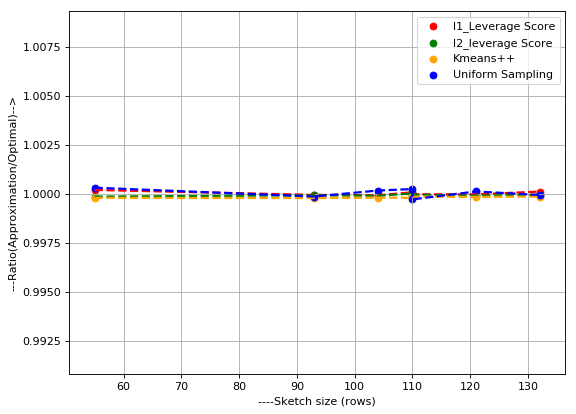

In [307]:
print("T3: dimension of matrix-",n,"x",d)
mcp = np.full((3,row),np.inf)
execute(A,b)
#print(l1normOpt)
# n = 2500 x 35 : T3 Data s = [row/25,row/32,row/40,row/50,row/64]

## T1 

In [34]:
A,b=T1(n,d)
x_opt = array(l1_regression(A,b))
l1normOpt = np.linalg.norm((A.dot(x_opt)-b),ord=1)
l1Matrix = np.zeros((len(factor),len(s)))
aug_A = np.c_[A,b]
row,col = aug_A.shape
#mcp = np.full((3,row),np.inf)
#execute(A,b)

25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25


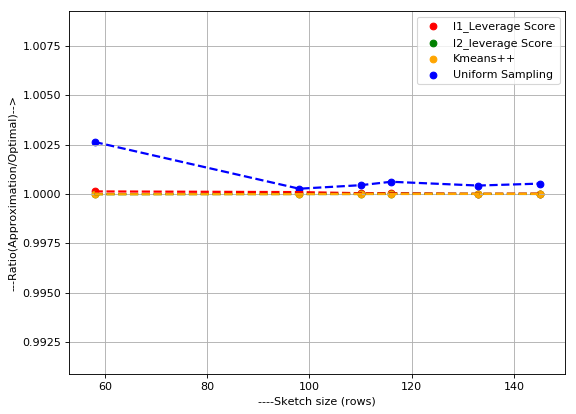

In [35]:
#leverageScore(A)
execute(A,b)

## Leverage Score Value and Plot

In [78]:
def leverageScore(A):
    u,e,vt = np.linalg.svd(A,full_matrices=False)
    leveragescore = np.sum(np.square(np.abs(u)),axis=-1)
    print(len(leveragescore))
    print(leveragescore)
    rows_pulled=[]
    for i in range(len(leveragescore)):
        if(leveragescore[i]>0.4):
            rows_pulled.append(i)
    print("len of rows pulled",len(rows_pulled),rows_pulled)
    index = []
    for i in range(2000):
        if i not in rows_pulled:
            index.append(i)
    
    A_new = A[index]
    print(A_new.shape)
    print("A rank:",np.linalg.matrix_rank(A))
    print("A_new rank:",np.linalg.matrix_rank(A_new))
    #LS_Plot(leveragescore)

In [79]:
leverageScore(A)

2000
[0.00209776 0.00507968 0.00518305 ... 0.01755425 0.05505847 0.0482673 ]
len of rows pulled 4 [136, 1100, 1449, 1636]
(1996, 26)
A rank: 26
A_new rank: 26


In [59]:
def LS_Plot(A):
    #print(np.multiply(A,100))
    print("LeverageScore Values:",A)
    print("Sum of leverage score:",sum(A))
    print("Number of Leverage Score Values:",A.shape)
    x,bins,p=plt.hist(A)
    for item in p:
        item.set_height((item.get_height()/sum(x)))
    plt.ylim([0, 1])
    #plt.figure(figsize=(30,10))
    #plt.yticks(arange(0,1.1,0.05))
    plt.ylabel("% of points in bin")
    plt.show()
    X = list(zip(x,bins))
    print("\n# of Points in:","-----------","%of Points","-------------------","bin:")
    for f,s in X:
        if f>0:
            print('{}'.format(int(f)),"--------------------------",'{:.3}'.format(f*100/sum(x)),"---------------------",s)
    #print("tuples:(numberOfPoints,bins)\n",list(zip(x,bins)))

LeverageScore Values: [5.32271398e-05 1.71635581e-05 7.96579444e-05 ... 5.24611588e-05
 4.75659359e-05 3.43907872e-04]
Sum of leverage score: 27.000000000000018
Number of Leverage Score Values: (3000,)


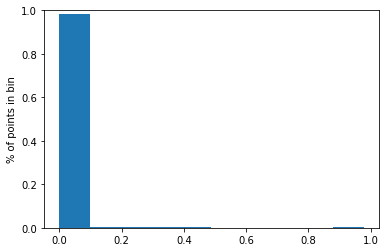


# of Points in: ----------- %of Points ------------------- bin:
2947 -------------------------- 98.2 --------------------- 1.096406005603429e-06
14 -------------------------- 0.467 --------------------- 0.09772216155688702
10 -------------------------- 0.333 --------------------- 0.19544322670776842
8 -------------------------- 0.267 --------------------- 0.29316429185864984
5 -------------------------- 0.167 --------------------- 0.39088535700953125
2 -------------------------- 0.0667 --------------------- 0.48860642216041267
3 -------------------------- 0.1 --------------------- 0.5863274873112941
1 -------------------------- 0.0333 --------------------- 0.6840485524621756
3 -------------------------- 0.1 --------------------- 0.781769617613057
7 -------------------------- 0.233 --------------------- 0.8794906827639384


In [191]:
leverageScore(A)

T1: dimension of matrix- 3000 x 27


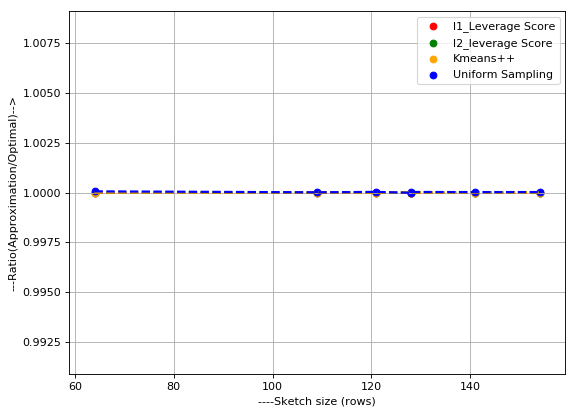

In [167]:
#run 1 : T1
print("T1: dimension of matrix-",n,"x",d)
mcp = np.full((3,row),np.inf)
execute(A,b)
#print(l1normOpt)

T1: dimension of matrix- 1500 x 32


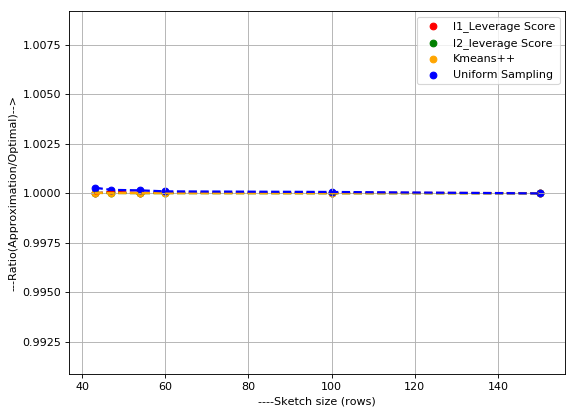

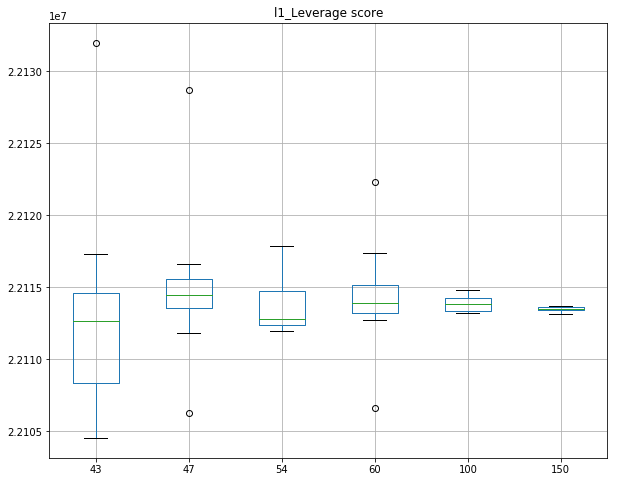

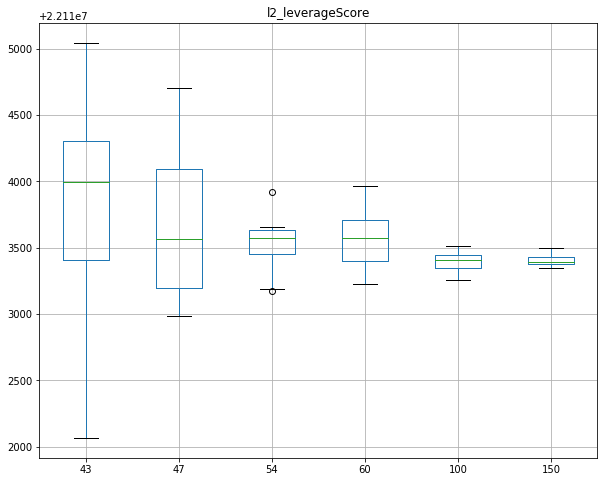

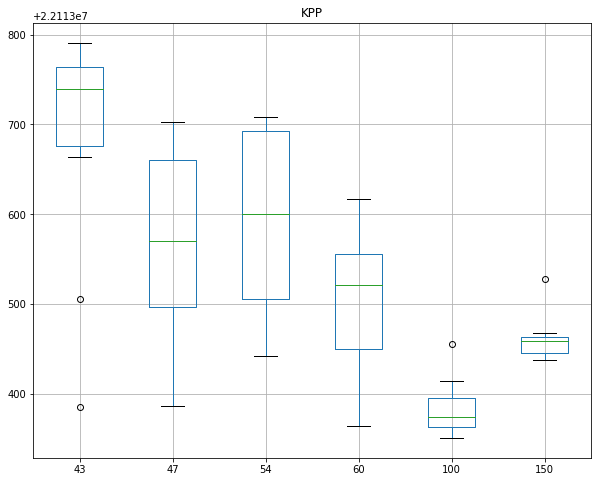

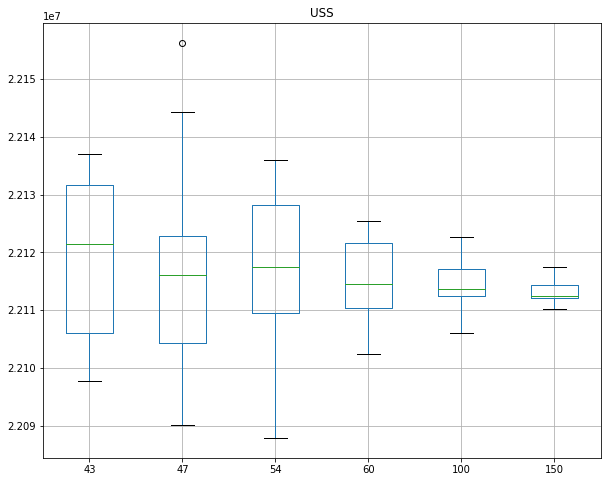

In [57]:
#run 1 : T1
print("T1: dimension of matrix-",n,"x",d)
mcp = np.full((3,row),np.inf)
execute(A,b)
#print(l1normOpt)

T1: dimension of matrix- 2500 x 30


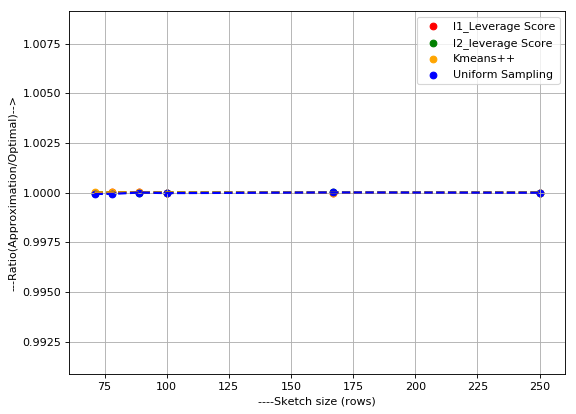

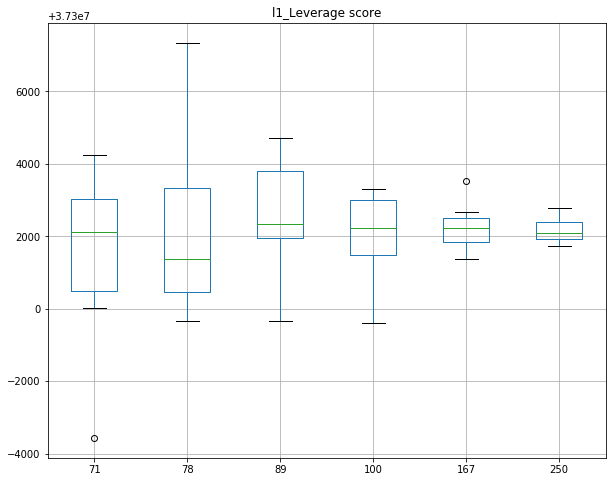

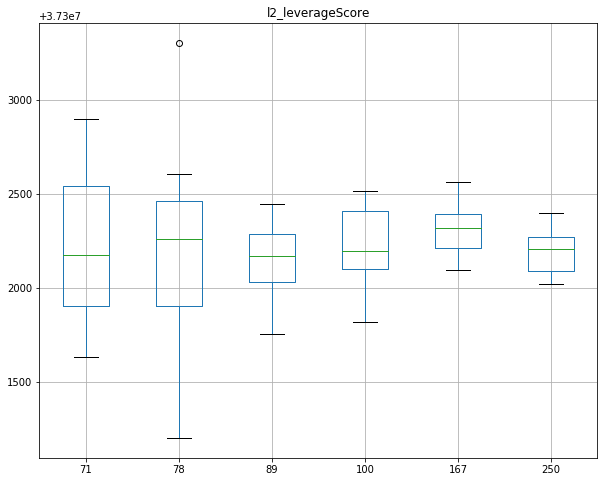

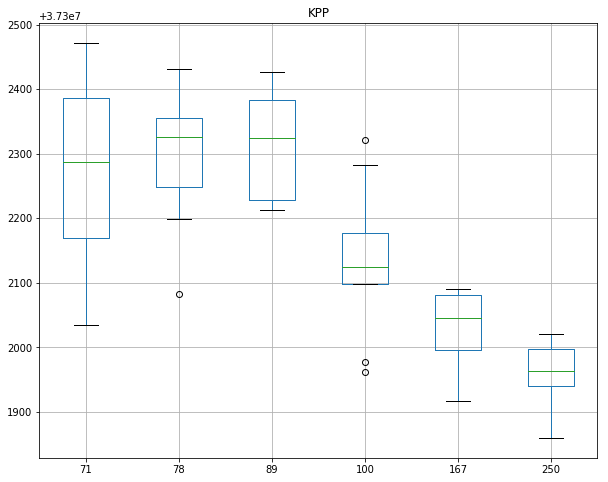

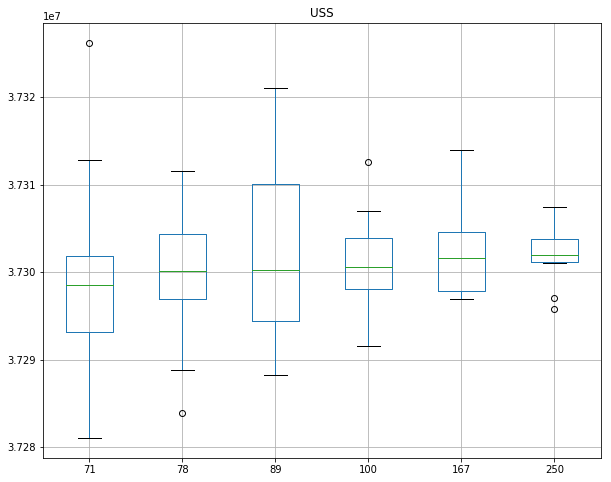

In [65]:
#run 2 : T1
print("T1: dimension of matrix-",n,"x",d)
mcp = np.full((3,row),np.inf)
execute(A,b)
#print(l1normOpt)

In [ ]:
print(l1normOpt)

# Testing Modules :: Irrelevant


In [23]:
testMatrix =np.ones((2000,26))

In [25]:
testMatrix

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [27]:
testMatrix[1999][:]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [36]:
temp1 = np.ones((1,13))
temp2=-1*np.ones((1,13))
#np.append(temp1,np.ones(1,13))

In [48]:
def USS_test(A):
    l1norm = []
    ratio=[]
    iter_data=[]
    for k in s:
        r=0
        temp_data=[]
        print("k is----",k)
        for i in range(10):
            index = np.random.choice(row,k,replace=False)
            #for t in range(k):
            #    index.append(int(random.uniform(0,row)))
            #index=randint(0, 9)
            #index = np.int_((np.random.uniform(low=0,high=row,size=k)))
            A_sketch = A[index,:]
            #b_sketch = b[index]
            print(np.linalg.matrix_rank(A_sketch))
            #x_tilde = array(l1_regression(A_sketch,b_sketch))
            #regression_value = np.linalg.norm((A.dot(x_tilde)-b),ord=1)
            #temp_data.append(regression_value)
            #r+=regression_value
        #r/=10
        #iter_data.append(temp_data)
        #l1norm.append(r)
    #ratio=np.array(l1norm)/np.array(l1normOpt)
    #return ratio,np.array(iter_data)

In [49]:
USS_test(testMatrix)

k is---- 61
1
1
1
1
1
1
1
1
1
1
k is---- 103
1
2
1
1
1
1
1
1
1
1
k is---- 116
1
1
1
1
1
1
1
1
1
1
k is---- 122
2
1
1
2
1
1
1
1
1
2
k is---- 140
1
1
1
1
1
1
1
1
1
1
k is---- 152
1
1
1
1
1
1
1
1
1
1


In [45]:
testMatrix

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.]])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a252a9898>,
      dtype=object)

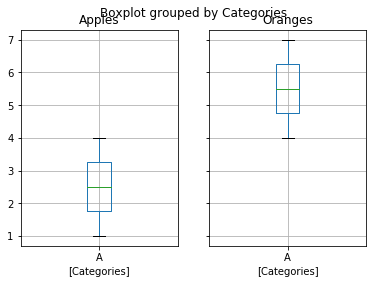

In [86]:
df = pd.DataFrame(np.array([[1,2,3,4],[4,5,6,7]]).T, columns=['Apples', 'Oranges'] )
df['Categories'] = pd.Series(list('AAAABBBBCCCC'))
#pd.options.display.mpl_style = 'default'
df.boxplot(by='Categories')

In [84]:
pd.Series(s)

0    100
1     40
2     36
3     31
4     29
dtype: int64

NameError: name 'np' is not defined

In [181]:
A,b = getData(n,d,

NameError: name 'string' is not defined